In [ ]:
import os
import re
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# directory paths for each docs we need for each task
script_dir = os.getcwd()
base_dir = os.path.join(script_dir, "text")
not_relevant_dir = os.path.join(script_dir, "artificial intelligence fairness")
stop_words_path = os.path.join(script_dir, "stop_words.txt")
museum_dir = os.path.join(script_dir, "museum visitors guide")
mobile_dir = os.path.join(script_dir, "mobile tourist guides")

# Ensuring the directory exists  to avoid errorss
if not os.path.exists(base_dir):
    print(f"Error: The folder '{base_dir}' does not exist!")
    exit()
else:
    print("Path exists:", os.path.exists(base_dir))

# Function to tokenize text
def tokenize(text):
    return re.findall(r'\b\w+\b', text) 

# Load stop words
def load_stop_words(file_path):
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            return set(f.read().splitlines())
    print("Stop words file not found!")
    return set()

stop_words = load_stop_words(stop_words_path)

# Function to remove stop words
def remove_stop_words(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Function to save language model
def save_language_model(tokens, filename):
    token_freq = Counter(tokens)
    file_path = os.path.join(script_dir, filename)
    with open(file_path, "w", encoding="utf-8") as f:
        for word, freq in token_freq.most_common():
            f.write(f"{word} {freq}\n")

# Apply preprocessing tokenization, stop word , stemming
stemmer = PorterStemmer()
all_tokens = []
filtered_tokens = []
tokens_lowercase = []
tokens_stemmed = []
tokenized_docs = []
labels = []

# Process relevant documents
for filename in os.listdir(base_dir):
    if filename.endswith(".txt") :  
        file_path = os.path.join(base_dir, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            tokens = tokenize(text)
            all_tokens.extend(tokens)
            tokens_no_stop = remove_stop_words(tokens)
            filtered_tokens.extend(tokens_no_stop)
            tokens_lowercase.extend([word.lower() for word in tokens])
            tokens_stemmed.extend([stemmer.stem(word) for word in tokens])
            
            tokenized_docs.append(" ".join(tokens_no_stop))  # Create text for classification
            labels.append(1)  # Label as relevant for classification task


# Save different versions of tokens
save_language_model(all_tokens, "tokens_frequency.txt")
save_language_model(filtered_tokens, "tokens_no_stopwords_frequency.txt")
save_language_model(tokens_lowercase, "tokens_lowercase_frequency.txt")
save_language_model(tokens_stemmed, "tokens_stemmed_frequency.txt")

# Save processed tokens into files
def save_tokens(filename, tokens):
    with open(os.path.join(script_dir, filename), "w", encoding="utf-8") as f:
        f.write("\n".join(tokens))

save_tokens("tokens.txt", all_tokens)
save_tokens("tokens_no_stopwords.txt", filtered_tokens)
save_tokens("tokens_lowercase.txt", tokens_lowercase)
save_tokens("tokens_stemmed.txt", tokens_stemmed)

print("Tokenization and language model processing complete.")

Path exists: True
Tokenization and language model processing complete.


In [ ]:
# --- Classification Task ---
from sklearn.metrics import confusion_matrix, classification_report


# Process non-relevant documents
for filename in os.listdir(not_relevant_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(not_relevant_dir, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            tokens = tokenize(text)
            tokens_no_stop = remove_stop_words(tokens)

            tokenized_docs.append(" ".join(tokens_no_stop))  
            labels.append(0)  # Label as non-relevant

# Just a check to see if we got 100 documents
print(f"Total documents processed: {len(tokenized_docs)}")

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(tokenized_docs, labels, test_size=0.2, random_state=42)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 4 classifers we chooseed 
classifiers = [
    ("Naive Bayes", MultinomialNB()),
    ("SVM", SVC(kernel='linear')),
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier(n_estimators=100))
]

# Perform 10-fold cross-validation and print each fold score
for name, clf in classifiers:
    scores = cross_val_score(clf, X_train_vec, y_train, cv=10)
    print(f"\n{name} 10-fold cross-validation scores:")
    for i, score in enumerate(scores, start=1):
        print(f"  Fold {i}: {score:.4f}")
    print(f"{name} Average: {scores.mean():.4f} ± {scores.std():.4f}")


# Train classifiers, evaluate on test set, and compute confusion matrix with metrics
for name, clf in classifiers:
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    accuracy = clf.score(X_test_vec, y_test)
    print(f"\n{name} Test Accuracy: {accuracy:.4f}")
    
    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} Confusion Matrix:")
    print(cm)
    
    # true negatives, false positives, false negatives, true positives
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        print(f"True Negatives: {TN}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Positives: {TP}")
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

print("Classification completed.")


Total documents processed: 100

Naive Bayes 10-fold cross-validation scores:
  Fold 1: 0.8750
  Fold 2: 0.5000
  Fold 3: 0.7500
  Fold 4: 0.7500
  Fold 5: 0.7500
  Fold 6: 0.8750
  Fold 7: 1.0000
  Fold 8: 0.8750
  Fold 9: 0.8750
  Fold 10: 1.0000
Naive Bayes Average: 0.8250 ± 0.1392

SVM 10-fold cross-validation scores:
  Fold 1: 1.0000
  Fold 2: 1.0000
  Fold 3: 1.0000
  Fold 4: 0.8750
  Fold 5: 1.0000
  Fold 6: 0.8750
  Fold 7: 1.0000
  Fold 8: 1.0000
  Fold 9: 1.0000
  Fold 10: 1.0000
SVM Average: 0.9750 ± 0.0500

Logistic Regression 10-fold cross-validation scores:
  Fold 1: 0.8750
  Fold 2: 0.8750
  Fold 3: 1.0000
  Fold 4: 1.0000
  Fold 5: 1.0000
  Fold 6: 0.7500
  Fold 7: 1.0000
  Fold 8: 1.0000
  Fold 9: 1.0000
  Fold 10: 1.0000
Logistic Regression Average: 0.9500 ± 0.0829

Random Forest 10-fold cross-validation scores:
  Fold 1: 0.8750
  Fold 2: 1.0000
  Fold 3: 0.8750
  Fold 4: 0.8750
  Fold 5: 1.0000
  Fold 6: 0.7500
  Fold 7: 1.0000
  Fold 8: 1.0000
  Fold 9: 1.0000
  Fold

Document: Data Mining Knowledge Discover... Cluster: 2
Document: Artificial Intelligence Medici... Cluster: 2
Document: Review Taxonomies Explainable ... Cluster: 2
Document: Received 18 June 2023 accepted... Cluster: 2
Document: IEEE TRANSACTIONS NEURAL NETWO... Cluster: 2
Document: applied sciences Systematic Re... Cluster: 2
Document: Received October 13 2021 accep... Cluster: 2
Document: Downloaded www annualreviews o... Cluster: 2
Document: diagnostics Review Application... Cluster: 2
Document: Knowledge Engineering Review V... Cluster: 2
Document: Science Engineering Ethics 202... Cluster: 2
Document: Better Metrics Evaluating Expl... Cluster: 2
Document: Building Explainable Artificia... Cluster: 2
Document: machine learning knowledge ext... Cluster: 2
Document: Deep Learning Security DARPA s... Cluster: 2
Document: Thirty Fifth AAAI Conference A... Cluster: 2
Document: Review Article https doi org 1... Cluster: 2
Document: Comment Explainability artific... Cluster: 2
Document: 

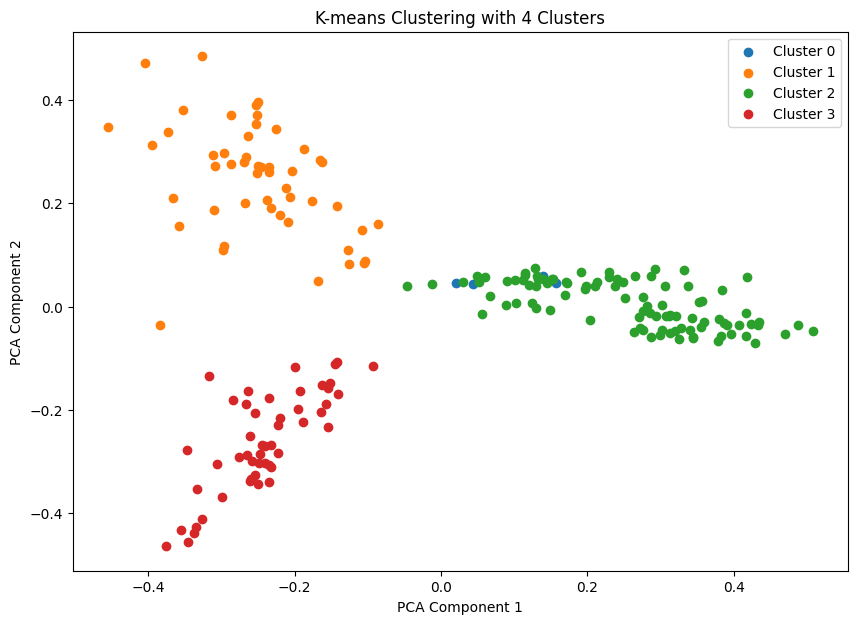

Clustering completed


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine documents from all directories with unique labels
all_docs = []
all_labels = []

#for one of the groups utf-8 didnt work so we used latin-1 and cp1252 encoding to read the files
def process_directory(directory, label):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            text = None
            for encoding in ['utf-8', 'latin-1', 'cp1252']:
                try:
                    with open(file_path, "r", encoding=encoding) as file:
                        text = file.read()
                    break  
                except UnicodeDecodeError:
                    continue  
                except Exception as e:
                    print(f"Error reading {file_path} with {encoding} encoding. Skipping this file.")
                    break  
            if text is None:
                print(f"Error reading {file_path}. Skipping this file.")
                continue
            tokens = tokenize(text)
            tokens_no_stop = remove_stop_words(tokens)
            all_docs.append(" ".join(tokens_no_stop))
            all_labels.append(label)

# Assign unique labels to each directory
process_directory(base_dir, "base") #our query
process_directory(not_relevant_dir, "fairness") #query from classification task
process_directory(museum_dir, "museum")
process_directory(mobile_dir, "mobile")

# Vectorize the combined documents using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_docs)

# Apply K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Analyze the results
clusters = kmeans.labels_

# Print the cluster 
for doc, cluster in zip(all_docs, clusters):
    print(f"Document: {doc[:30]}... Cluster: {cluster}")

# Analyze errors
label_to_cluster = {label: [] for label in set(all_labels)}
for label, cluster in zip(all_labels, clusters):
    label_to_cluster[label].append(cluster)

for label, cluster_list in label_to_cluster.items():
    print(f"Label: {label}, Cluster distribution: {np.bincount(cluster_list)}")

# Visualize the clusters using PCA helps us to see the spread of the clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
for i in range(4):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('K-means Clustering with 4 Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

print("Clustering completed")